# Build DCGAN

## Import

In [1]:
import argparse
import os
import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchnet.meter import AverageValueMeter

## Define Arguments

In [8]:
%ll ./data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/

total 1564
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 7 For All Mankind Kids/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 adidas/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 adidas by Stella McCartney/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 adidas Golf/
drwxrwxr-x 2 hminle 12288 Apr 22 21:32 adidas Kids/
drwxrwxr-x 2 hminle 12288 Apr 22 21:32 adidas Originals/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 adidas Originals Kids/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 adidas Outdoor/
drwxrwxr-x 2 hminle 12288 Apr 22 21:32 adidas Running/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 adidas Y-3 by Yohji Yamamoto/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 Aetrex/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 Agatha Ruiz De La Prada Kids/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 Ahnu/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 ALDO/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 Alexander McQueen/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 Allrounder by Mephisto/
drwxrwxr-x 2 hminle  4096 Apr 22 21:32 Altra Zero Drop Footwear/
drwxrwxr-x 2 hminl

In [62]:
parser = {
    'data_path': './data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/',
    'epochs': 2,
    'batch_size': 64,
    'lr': 0.0002,
    'image_size': 136,
    'scale_size': 64,
    'z_dim': 100,
    'G_features': 64,
    'D_features': 64,
    'image_channels': 3,
    'beta1': 0.5,
    'cuda': False,
    'seed': 7,
    'workers': 2,
    'results': './results/'
}
args = argparse.Namespace(**parser)

args.cuda = args.cuda and torch.cuda.is_available()

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
if not os.path.isdir(args.results):
    os.makedirs(args.results)
    
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## Prepare Data

**Note: all iamges have size 136x102**

In [49]:
from folder import ImageFolder

In [50]:
from torchvision.transforms import ToPILImage
to_image = ToPILImage()

In [63]:
def get_loader(image_root, batch_size, scale_size, num_workers=2, shuffle=True):
    #image_root = os.path.join(root, 'splits', split)
    dataset = ImageFolder(root=image_root, transform=transforms.Compose([
            transforms.Pad(35, fill=(255, 255, 255)), # padding images with (255,255,255) --> pad 255 in 3 channels
            transforms.CenterCrop((136,136)),
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=int(num_workers))
    #data_loader.shape = [int(num) for num in dataset[0][0].size()]

    return data_loader

In [64]:
dataloader = get_loader(args.data_path, args.batch_size, args.scale_size)

Found 12856 images in subfolders of: ./data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/


### Test One Image

In [65]:
test_image = 0
for data, _ in dataloader:
    print(data[0])
    test_image = data[0]
    break


(0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...            

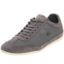

In [66]:
to_image(test_image)

## Define Model

### Define G

In [38]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(args.z_dim, args.G_features * 8,
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(args.G_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(args.G_features * 8, args.G_features * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.G_features * 4, args.G_features * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.G_features * 2, args.G_features,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(args.G_features, args.image_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, x):
        return self.main(x)

### Define D

In [39]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(args.image_channels, args.D_features,
                      4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(args.D_features, args.D_features * 2,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(args.D_features * 2, args.D_features * 4,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(args.D_features * 4, args.D_features * 8,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(args.D_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

## Define Train and Generate

In [40]:
def train(args, data_loader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch):
    D_losses = AverageValueMeter()
    G_losses = AverageValueMeter()
    D_reals = AverageValueMeter()
    D_fakes = AverageValueMeter()
    G_reals = AverageValueMeter()
    
    start = time.time()
    # call Variable after .cuda()
    for i, (real, _) in enumerate(data_loader):
        batch_size = real.size(0)
        real_label = torch.ones(batch_size)
        fake_label = torch.zeros(batch_size)
        z = torch.randn(batch_size, args.z_dim, 1, 1)
        if args.cuda:
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            real = real.cuda()
            z = z.cuda()
        real_label = Variable(real_label)
        fake_label = Variable(fake_label)
        real = Variable(real)
        z = Variable(z)
        
        real_output = netD(real)
        D_real_loss = criterion(real_output, real_label)
        D_real = real_output.data.mean()
        
        fake = netG(z)
        fake_output = netD(fake.detach())
        D_fake_loss = criterion(fake_output, fake_label)
        D_fake = fake_output.data.mean()
        
        D_loss = D_real_loss + D_fake_loss
        netD.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        output = netD(fake)
        G_loss = criterion(output, real_label)
        G_real = output.data.mean()
        netG.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        D_losses.add(D_loss.data.cpu()[0] * batch_size, batch_size)
        G_losses.add(G_loss.data.cpu()[0] * batch_size, batch_size)
        D_reals.add(D_real * batch_size, batch_size)
        D_fakes.add(D_fake * batch_size, batch_size)
        G_reals.add(G_real * batch_size, batch_size)
        
    print("=> EPOCH {} | Time: {}s | D_loss: {:.4f} | G_loss: {:.4f}"
          " | D_real: {:.4f} | D_fake: {:.4f} | G_real: {:.4f}"
          .format(epoch, round(time.time()-start), D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0]))

In [70]:
def generate(args, netG, epoch):
    z = torch.randn(args.batch_size, args.z_dim, 1, 1)
    if args.cuda:
        z = z.cuda()
    fake = netG(Variable(z, volatile=True))
    save_image(fake.data.cpu(), os.path.join(args.results,
        "fake_sample_epoch_{:02d}.png".format(epoch)), normalize=True)

## Create Model, Define Loss and Optimizer

In [67]:
netG = _netG()
netD = _netD()
criterion = nn.BCELoss()
if args.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()

In [68]:
D_optimizer = optim.Adam(netD.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999))
G_optimizer = optim.Adam(netG.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999))

## Run Train

In [69]:
for epoch in range(1, args.epochs+1):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch)
    generate(args, netG, epoch)

=> EPOCH 1 | Time: 874s | D_loss: 0.7784 | G_loss: 8.1453 | D_real: 0.8407 | D_fake: 0.1764 | G_real: 0.0300


AttributeError: 'Namespace' object has no attribute 'intermediate_path'

## Get one REAL Image

In [72]:
sample, _ = iter(dataloader).next()
save_image(sample, os.path.join(args.results, "real_sample.png"))